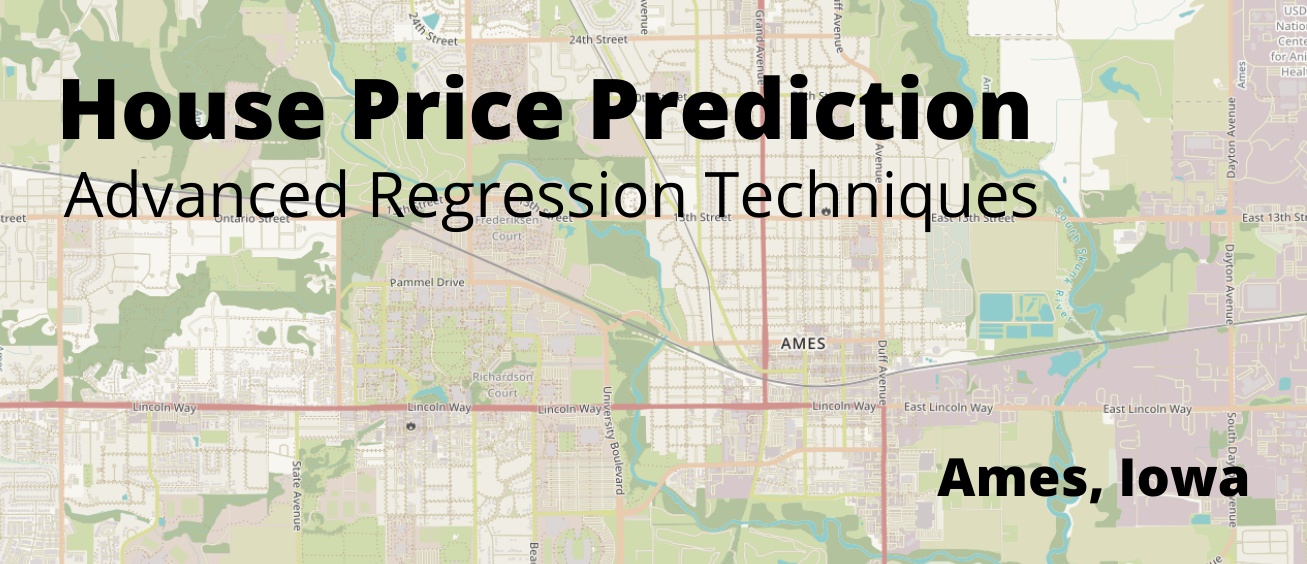

# Overview

The Ames housing dataset was compiled in 2011 as a substitute for the Boston dataset. It consists of 79 attributes about real estate, with descriptions that a buyer would never think of. Precisely because it is so descriptive, it is perfect for a machine learning task, in which we can use algorithms to find the most diverse patterns that would go unnoticed even by the most experienced broker. 

In this noteboot I will do:
1. Exploratory data analysis
     - Understand the data
     - Find interesting patterns in the dataset
2. Pre-process the data
     - Treat missing records
     - Encode categorical data
     - Remove outliers
     - Normalize the data
3. Build several models and evaluate them

# Importing libraries

In [79]:
"""Importing data manipulation and processing"""
import pandas as pd
import numpy as np

"""Importing OS and date manipulation libraries"""
import os
import datetime

"""Importing graphics and data vizualization libraries"""
import matplotlib.pyplot as plt
import seaborn as sns

"""Importing data processing and data statistics"""
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer

"""Importing model methods and metrics"""
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

"""Importing regression algorithms"""
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, ARDRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,  AdaBoostRegressor, GradientBoostingRegressor

# Importing dataset

In [2]:
"""Importing data"""
data = pd.read_csv('../data/train.csv')
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
"""Verifying shape"""
data.shape

(1460, 81)

## Separating the Numerical and Categorical columns

Most of the columns have a datatype that is befitting, but some of them need to be put in the right list. This happens to ```MSSubClass```, ```OverallQual```, and ```OverallCond```.

In the case of ```MSSubClass```, although this column has numerical values, the true meaning of them is just a categorization to identify the type of dwelling involved in the sale. Because of that, I will transfer it to the categorical list. The same goes for ```OverallQual```, and ```OverallCond```, which are numeric (ranging from 1 to 10) but they are more 
subjective and categorical, so I transfer them to the categorical list.

In the end we have **46 categorical** columns and **33 numerical** columns. 

In [4]:
numerical = [f for f in data.columns if data.dtypes[f] != 'object']
numerical.remove('SalePrice')
numerical.remove('Id')
categorical = [f for f in data.columns if data.dtypes[f] == 'object']

numerical.remove("MSSubClass")
categorical.append("MSSubClass")

""" """ 
numerical.remove("OverallQual")
numerical.remove("OverallCond")
categorical.append("OverallQual")
categorical.append("OverallCond")

print("Number of categorical columns: {}".format(len(categorical)))
print("Number of numerical columns: {}".format(len(numerical)))

Number of categorical columns: 46
Number of numerical columns: 33


## Definition of auxiliary and plot functions

In [5]:
def missing_data(columns):
    """Receives a list of columns and return a Series with the number of missing values in each column"""
    missing = data[columns].isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(ascending=False, inplace=True)
    return missing

def plot_nan(data, **kwargs):
    """Receives a Series with the missing values and plot a Bar Plot"""
    sns.set_theme(style="whitegrid", context="talk")
    f, ax1 = plt.subplots(1, 1, figsize=(10, 7))
    sns.barplot(x=data.values, y=data.index, palette="winter_r", ax=ax1, orient="h", **kwargs)
    sns.set(font_scale=2)
    ax1.set_xlabel("Number of NaN values")
    plt.plot()
    
def plot_dist(data, figsize=(10, 7), **kwargs):
    """Receives a Series and plot it's distribution"""
    sns.set_theme(style="ticks", context="talk")
    f, ax1 = plt.subplots(1, 1, figsize=figsize)
    sns.histplot(data, color="g", ax=ax1, kde=True, line_kws={"lw":3}, **kwargs)
    sns.set(font_scale=2)
    plt.plot()

def box_plot(x, y, data, legend={}, figsize=(9, 7), **kwargs):
    """Receives a DataFrame and plot the x and y as a Box Plot, if the legend is provided it replaces 
    the x_tick labels"""
    plt.subplots(figsize=figsize)
    sns.set_theme(style="whitegrid", context="talk")
    sns.set(font_scale=2)
    
    x_legend, x_label = create_ticklabels(legend, x)
        
    sns.boxplot(x=x, y=y, data=data[[x, y]], **kwargs)
    if len(legend) > 10:
        plt.xticks(ticks=range(0, len(legend)), labels=x_legend, rotation=90)
    elif len(legend) <= 10 and len(legend) > 0:
        plt.xticks(ticks=range(0, len(legend)), labels=x_legend, rotation=0)
    
    plt.xlabel(x_label, size=15)    
    plt.ylabel(y, size=15)
    plt.plot()

def create_ticklabels(legend, x):
    """Receives the encoded legend and returns the x_tick labels for that plot"""
    x_legend = []
    if x[-1] == "E":
        for x_tick in range(1, len(legend)+1):
            x_legend.append(legend[x_tick])
        
        x_label = x[:-2]
    else:
        x_label = x
    return x_legend, x_label 
    
def scatter_plot(x, y, data,figsize=(9, 7), **kwargs):
    """Receives a DataFrame and plot the x and y as a Scatter Plot"""
    plt.subplots(figsize=figsize)
    sns.set_theme(style="whitegrid", context="talk")
    sns.set(font_scale=2)
    sns.scatterplot(x=x, y=y, data=data, **kwargs)
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)
    plt.plot()
    
def triang_corr_plot(corr, figsize=(18, 18), mask=True, square=True, cmap=False, **kwargs):
    """Receives a correlation table and plots the correlation table, in case mask is True, 
    creates a triangular plot with the unique correlations"""
    if figsize != (0, 0):
        f, ax = plt.subplots(figsize=figsize)
    
    if mask:
        mask = np.triu(np.ones_like(corr, dtype=bool))
    else:
        mask = np.zeros_like(corr, dtype=bool)
    
    if not cmap:
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        
    sns.set(font_scale=2)
    sns.heatmap(corr,square=square, mask=mask, cmap=cmap, linewidths=.1, cbar_kws={"shrink": .5}, **kwargs)
    plt.plot()

def reg_plot(x, y, data, height=9, color="g", alpha=0.25, **kwargs):
    """Receives a DataFrame and plot the Regression Plot between x and y, as well as the line of the regression 
    Pearson correlation coeficient"""
    plt.figure(figsize = (9,8))
    sns.set(font_scale=2)
    sns.set_theme(style="whitegrid", context="talk")
    sns.jointplot(x=x, y=y, data=data, kind="reg", height=9, color=color, scatter_kws={'alpha':alpha})
    plt.legend(['$Pearson=$ {:.2f}'.format(data.corr(method="pearson")["SalePrice"][0])], loc = 'best')
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)
    plt.plot()


# Initial pre-processing data

## Ploting the missing data

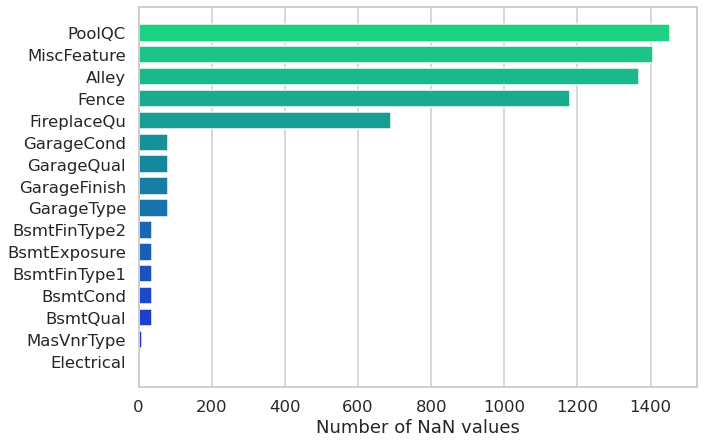

In [6]:
"""Ploting the missing data in the categorical data"""
cat_miss = missing_data(categorical)
plot_nan(cat_miss)

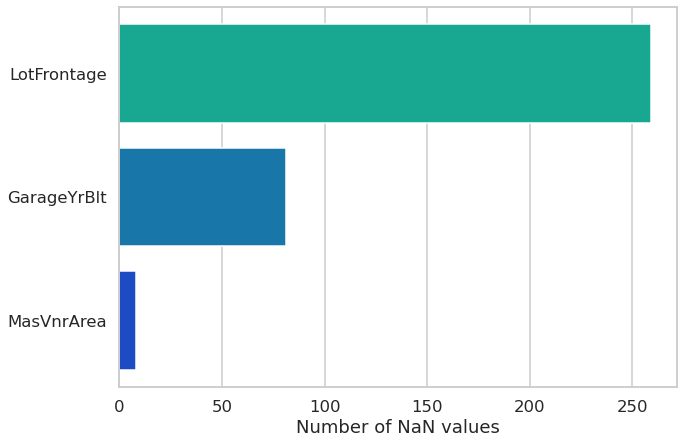

In [7]:
"""Ploting the missing data in the numerical data"""
num_miss = missing_data(numerical)
plot_nan(num_miss)

## Filling missing data
The data description for ```PoolQ```, ```MiscFeature```, ```Alley```, ```Fence```, ```FireplaceQu```, ```GarageCond```, ```GarageQual```, ```GarageFinish```, ```GarageType```, ```BsmtFinType2```, ```BsmtExposure```, ```BsmtFinType1```, ```BsmtCond```, and ```BsmtQual```, says clearly that the NaN values stand for No Pool, No alley access, No Garage and so on. Because of that we are going to substitute all NaN in those categorical atributes for "None". Besides that, there is a NaN value in ```MasVnrType```, and e will substitute for "None" too, seeing that this class already exist.

Also, the one record that has a NaN in the ```Electrical``` atribute will be droped, because one record will not affect the regression algorithms.

Finally, the NaN values in the ```LotFrontage```, ```GarageYrBlt``` and ```MasVnrArea``` will be set to zero because they are numerical columns.

In [8]:
"""Filling all the NaNs, and droping the missing Eletrical"""
data.dropna(subset=['Electrical'], inplace=True)
for atribute in categorical:
    data[atribute] = data[atribute].fillna('None')
    
for atribute in numerical:
    data[atribute] = data[atribute].fillna(0)

In [9]:
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


# Exploratory Analysis 
## Numerical Correlation heatmap

Here I choose the Spearman correlation, because it is less sensitive than the Pearson correlation to strong outliers that are in the tails of both samples, seeing that we did not treated our data yet.

For a sample of size $n$, the $n$ raw scores $X_i$, $Y_i$ are converted to ranks $\operatorname{rg}_{X_i}, \operatorname{rg}_{Y_i}$ in crescent order, and $r_s$ is computed as

$r_s = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}$,

where $d_i$ is the difference between the two ranks of each observation,
$d_i = \operatorname{rg}(X_i) - \operatorname{rg}(Y_i)$.

The Spearman correlation will be $1$ when the function that describes the data is strictly monotonically increasing, that is, if for all $x$ and $y$ such that ${ x < y}$ one has 
${\displaystyle f\!\left(x\right)< f\!\left(y\right)}$. Likewise, the Spearman correlation will be $-1$ when the funcion that describes the data is strictly monotonically decreasing if, whenever $x < y$, then ${\displaystyle f\!\left(x\right)> f\!\left(y\right)}$.
This means that the relationship between the data doesn't need to be linear to have a strong correlation.

Here we can see some very strong positive correlations between numerical variables. Many of them are quite obvious, such as the strong correlation between ```GarageArea``` and ```GarageCars```, since the more cars that fit in the garage, the larger your area will be. There is also a correlation between ```TotRmsAbvGrd``` and ```GrLivArea```, again, the more rooms, the larger the total area of a building tends to have. The same can be observed between the correlation of ```1stFlrSF``` and ```TotalBsmtSF```, since the basement usually has the same area as the house.

Moving on to some more descriptive correlations of the data, we have the relationship between ```GarageYrBlt``` and ```GarageCars```, something that can be interesting to visualize. 

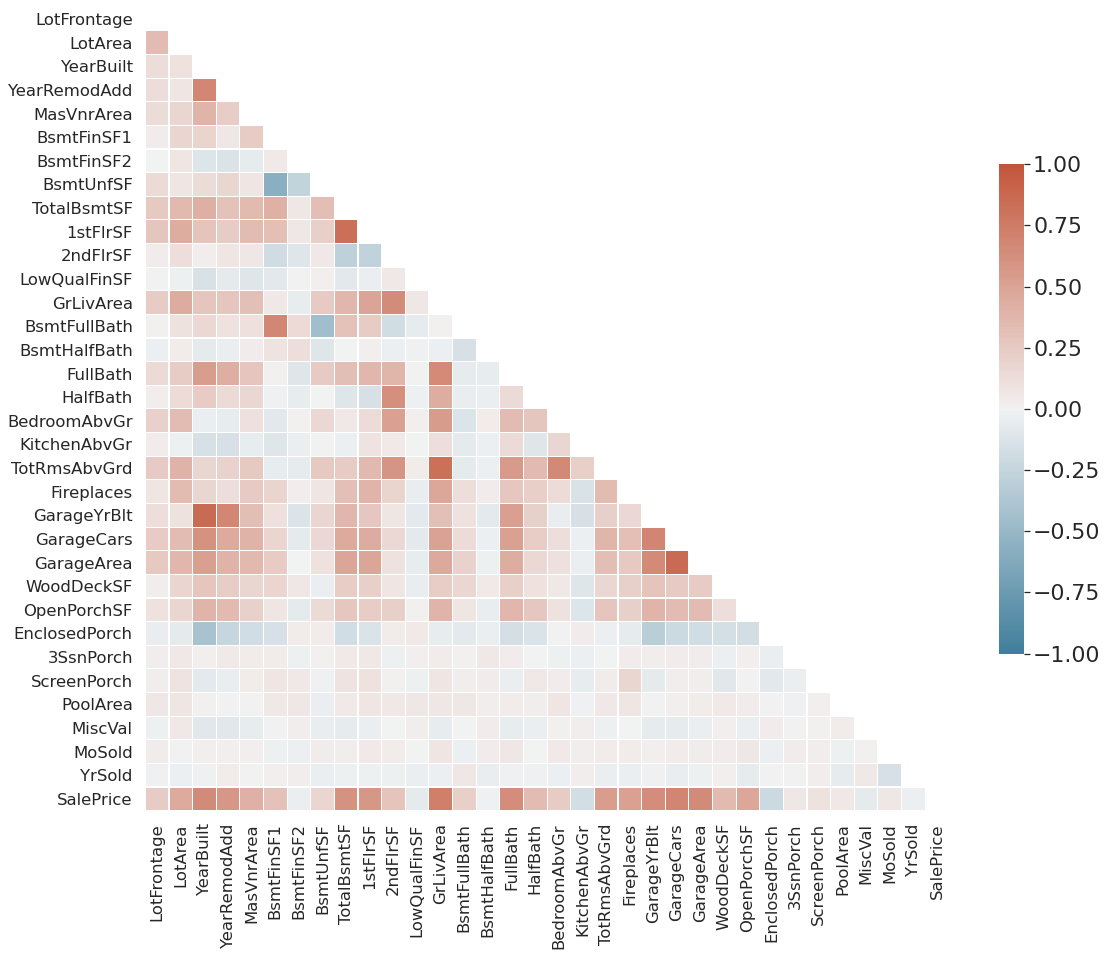

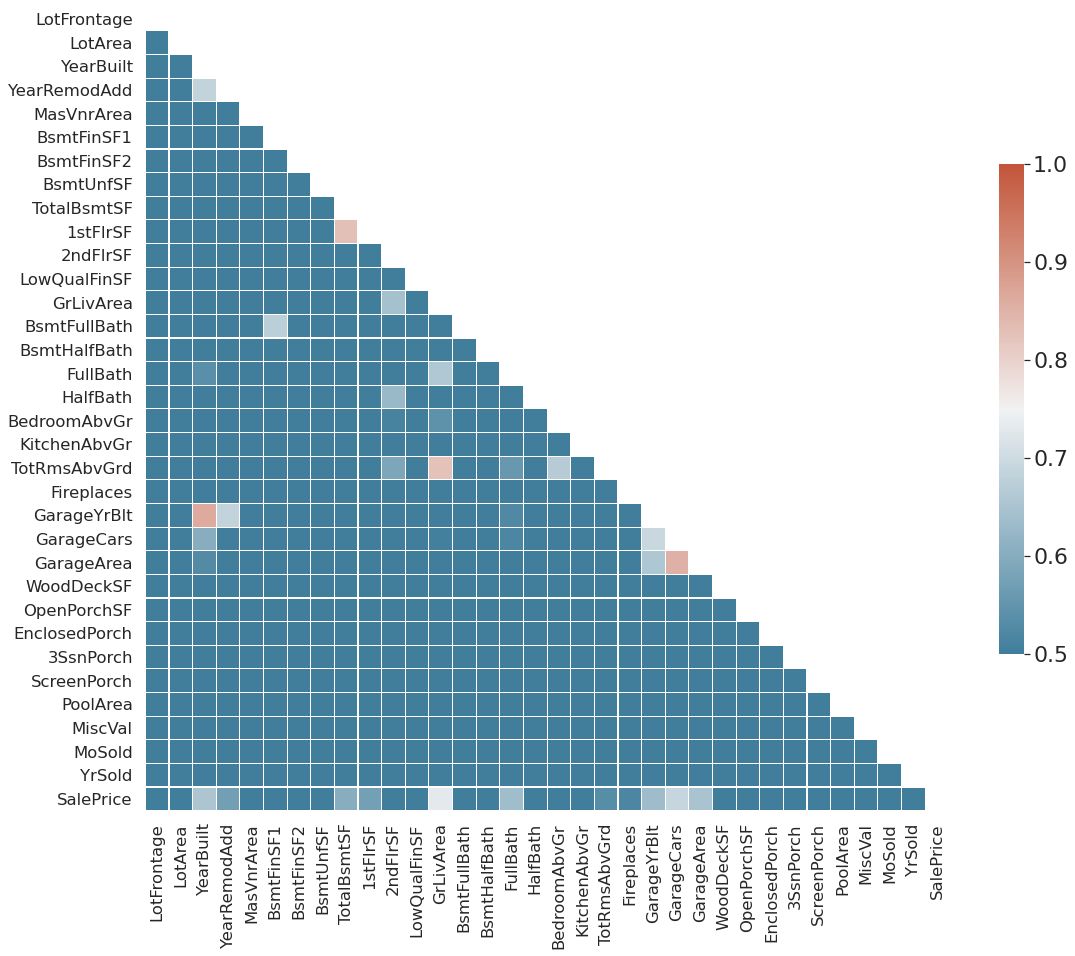

In [10]:
"""Ploting the correlation table using the Spearman correlation of the numerical variables"""
corr_num = data[numerical+["SalePrice"]].corr(method="spearman")
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_num, vmax=1, vmin=-1)
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_num, vmax=1, vmin=0.5)

## Encoding the Categorical atributes

Encoding the categorical variables as numbers, so we can calculate the correlation. 
Here we create the legend for the encoding, that will be used later to plot the categorical variables.

In [11]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    categories = {}
    for cat, o in ordering.items():
        categories[o] = cat
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    return categories
    
cat_encoded = []
legend_cat = {}
for q in categorical:
    legend_cat[q] = encode(data, q)
    cat_encoded.append(q+'_E')
print(cat_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E', 'MSSubClass_E', 'OverallQual_E', 'OverallCond_E']


## Categorical Correlation heatmap
Again we use spearman correlation.

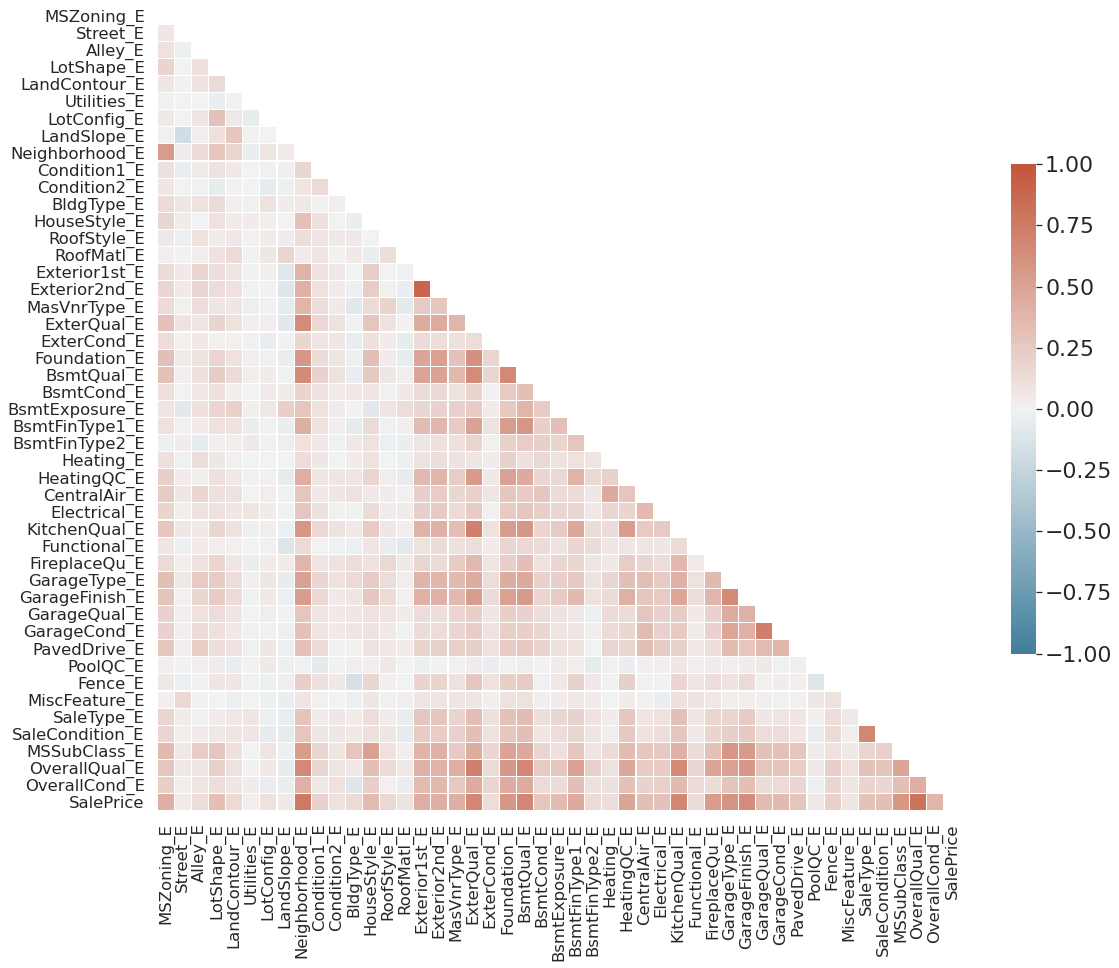

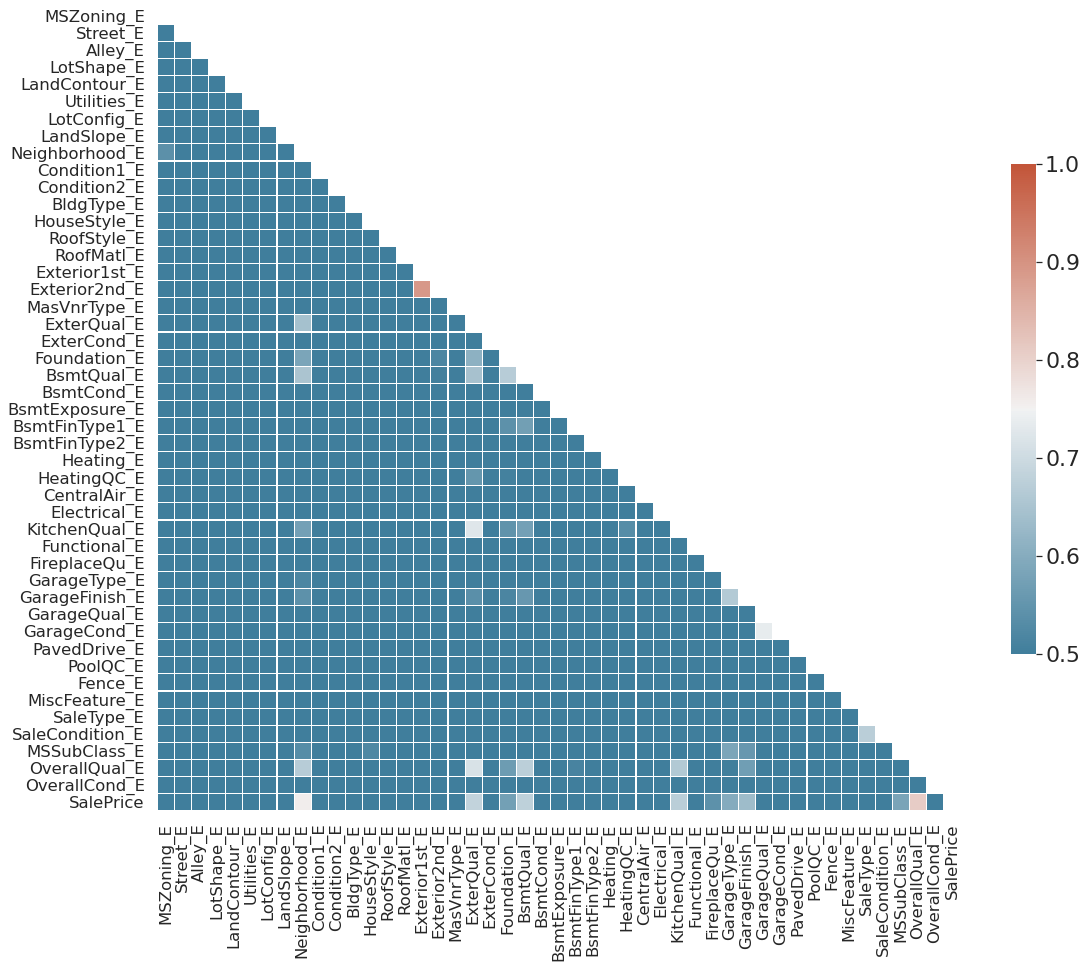

In [12]:
"""Ploting the correlation table using the Spearman correlation of the categorical variables"""
corr_cat = data[cat_encoded+["SalePrice"]].corr(method="spearman")
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_cat, vmax=1, vmin=-1)
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr_cat, vmax=1, vmin=0.5)

## Heatmap of the highest correlated variables
We can see that all the variables are strongly correlated, which is good sign that our models are going to find these correlations. These are the variables that I will spend most of my time, ploting, understanding, and cleaning, since they are the most correlated with our dependent variable, hence, the most important to our models.

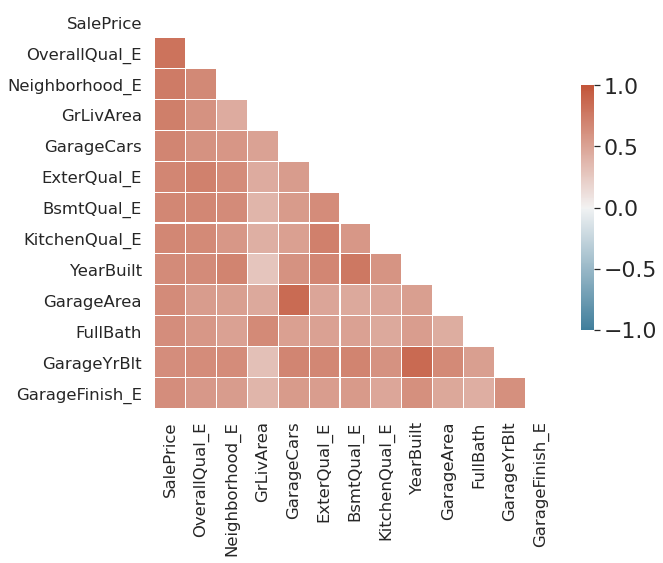

In [13]:
"""Selecting the highest correlated atributes on both the categorical and numerical columns"""
top_num = corr_num["SalePrice"].sort_values(ascending=False)[:7]
top_cat = corr_cat["SalePrice"].sort_values(ascending=False)[1:7]
top = top_cat.append(top_num).sort_values(ascending=False).index

"""Ploting their correlation"""
corr = data[top].corr(method="spearman")
sns.set_theme(style="whitegrid", context="talk")
triang_corr_plot(corr, vmax=1, vmin=-1, figsize=(9, 9))

corr_SalePrice = data[numerical + cat_encoded + ["SalePrice"]].corr()

## Box plot of the highest correlated atributes
### OverallQual
Rates the overall material and finish of the house, and we can see that there is a clear trend as the materials get better, the house prices get higher. It makes sense, since expensive houses tend to be constructed with better materials.

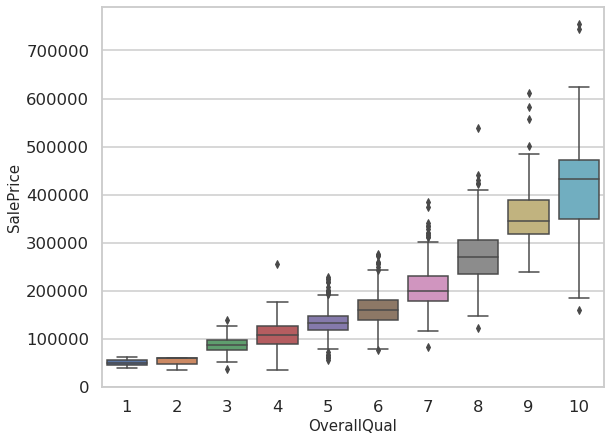

In [14]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[1], "SalePrice", data[[top[1], "SalePrice"]], legend=legend_cat[top[1][:-2]])

### Other Material Quality Atributes
```ExterQual```, evaluates the quality of the material on the exterior, while ```BsmtQual``` evaluates the **height** of the basement, and it is interesting to see that higher basements tend to be in expensive houses. Lastly, we have ```KitchenQual```, thtat evaluates the kitchen quality, no surprise in see that good quality kitchens are more expensive, who doesn't like to cook in a well constructed kitchen?

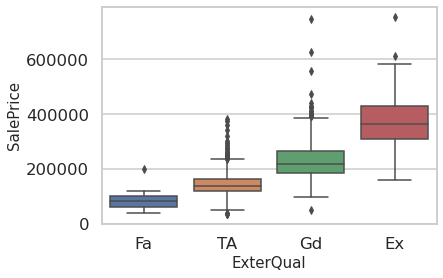

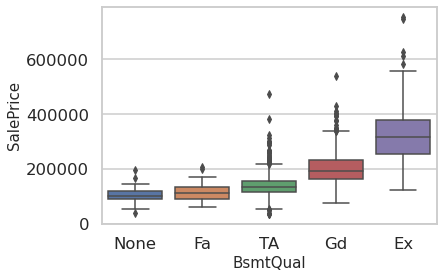

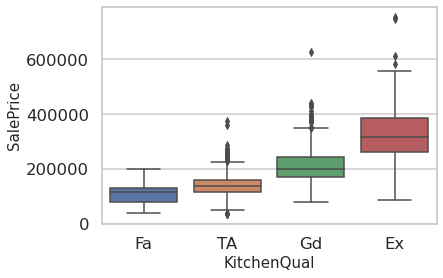

In [15]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[5], "SalePrice", data[[top[5], "SalePrice"]], legend=legend_cat[top[5][:-2]], figsize=(6, 4))

sns.set_theme(style="whitegrid", context="talk")
box_plot(top[6], "SalePrice", data[[top[6], "SalePrice"]], legend=legend_cat[top[6][:-2]], figsize=(6, 4))

sns.set_theme(style="whitegrid", context="talk")
box_plot(top[7], "SalePrice", data[[top[7], "SalePrice"]], legend=legend_cat[top[7][:-2]], figsize=(6, 4))

### Neighborhood
Physical locations within Ames city limits. This backup the commom sense, that houses within the same neighborhood have the same price. As we go from the poorest neighborhood to the rich ones, there is a correlation with the house prices.

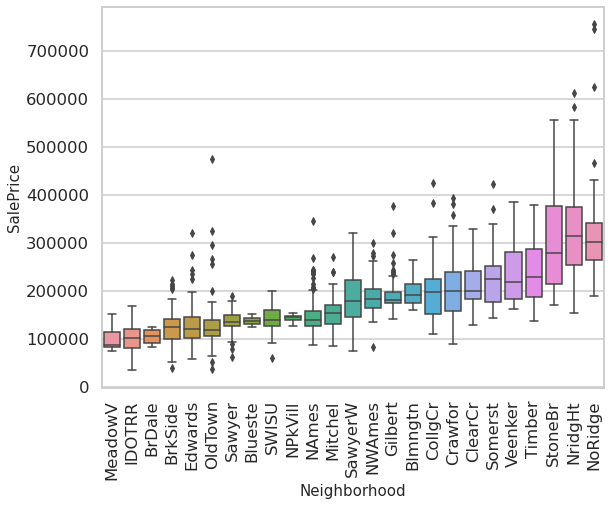

In [16]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[2], "SalePrice", data[[top[2], "SalePrice"]], legend=legend_cat[top[2][:-2]])

### FullBath
Full bathrooms above ground. We can see that having more bathrooms is associated with higher house prices. The reason to some houses have zero full bathrooms it's because not every bathroom is a full bathroom, to be considered one it need to have: a sink, a shower, a bathtub, and a toilet.


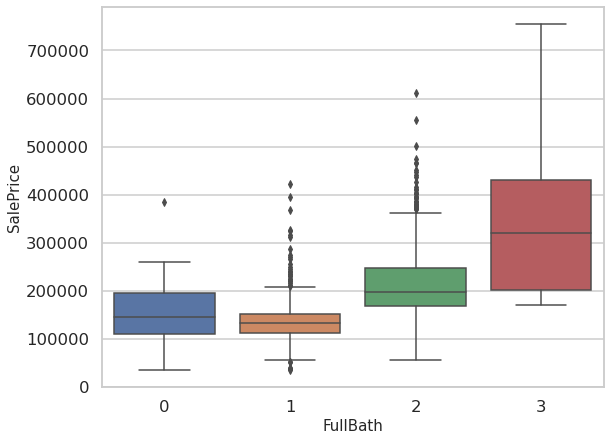

In [17]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[10], "SalePrice", data[[top[10], "SalePrice"]])

### GarageFinish
It tells if the interiorof the garage is finished, roughly finished, or if it is unfinished.

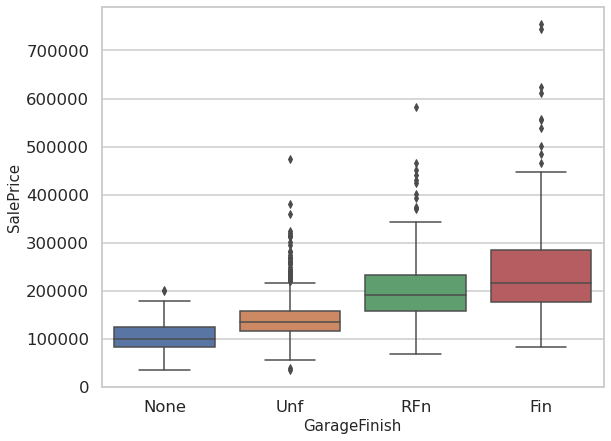

In [18]:
sns.set_theme(style="whitegrid", context="talk")
box_plot(top[12], "SalePrice", data[[top[12], "SalePrice"]], legend=legend_cat[top[12][:-2]])

### Ploting some interesting discoveries in the data
The year that the garage was built has a huge impact on the number of cars that it supports. Between the 1940s and the 1970s, most of the houses was built with only one car. Later, from the 1970s until the 2000s they started to built most houses with two cars, and from there the houses tend to have the capacity to three cars.
Also there is a correlation between capacity of the garage and the price of the house, we can see that houses with capacity to three cars have significant higher prices.  

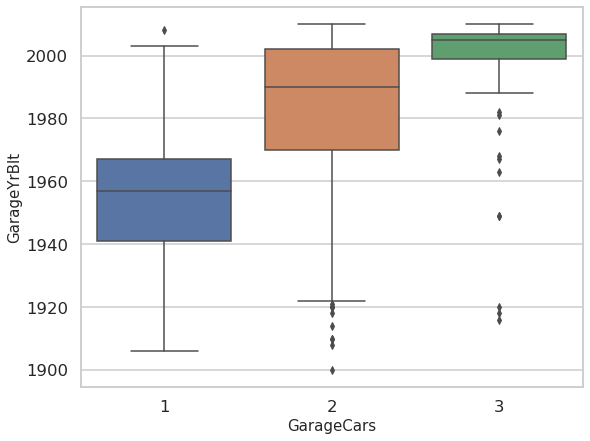

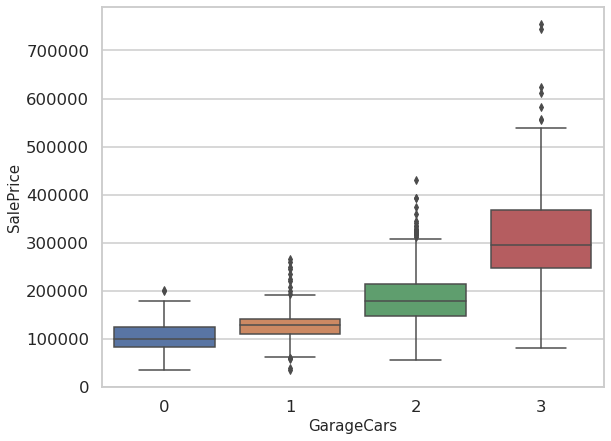

In [19]:
sns.set_theme(style="whitegrid", context="talk")
box_plot("GarageCars", "GarageYrBlt", data[(data.GarageYrBlt > 0) & (data.GarageCars > 0) & (data.GarageCars < 4)])

sns.set_theme(style="whitegrid", context="talk")
box_plot("GarageCars", "SalePrice", data[(data.GarageCars < 4)])

### The winter is coming to Ames 
This is Ames in February, and it is clear that the winter have a great impact in the sales, since having to go out in the blizzard to buy a house it's not the ideal thing to do. And we can see in the data how much this affects sales. 
<img src="https://bloximages.chicago2.vip.townnews.com/iowastatedaily.com/content/tncms/assets/v3/editorial/4/d4/4d4c7bb8-411f-11e9-936e-c30cdf51f1e5/5c818be6cce9b.image.jpg?resize=750%2C500" alt="winter" style="width:450px;"/>

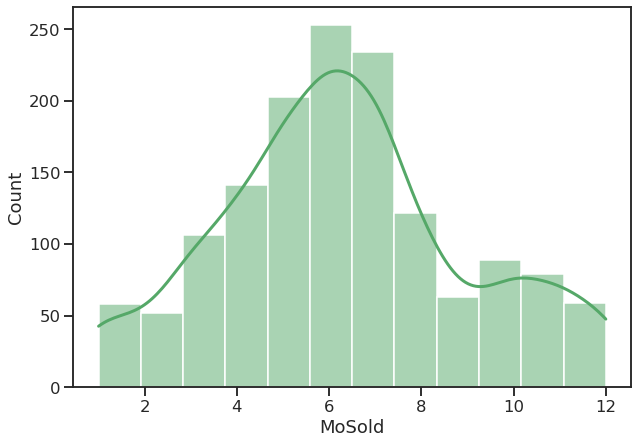

In [20]:
plot_dist(data["MoSold"], bins=12)

# Pre-processing
### Removing outliers and strengthening linear relationships
As we understand better our data we need to clean the outliers. Outliers can have a huge impact in our model later on, so for each variable a tried several limits to reduce them and increase the Pearson correlation.

The Person correlation is the best choice here, because we want to find and strengthen a linear relationship between the dependent variable ```y``` (```SalePrice```) and the independent variables ```X```. This linear relationship will be essential to the linear regression model later.

In the Person correlation, with a sample size $n$ is described as:

$r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$, where $x_i, y_i$ are the individual sample points indexed with $i$; And $\bar{x}=\frac{1}{n}\sum_{i=1}^n x_i$; and analogously for $\bar{y}$

The Pearson correlation is $1$ when a linear equation can describe perfectly the relationship between $X$ and $Y$, where with each increase in $X$, we have an increase in $Y$. The same applies to $-1$, but with each increase in $X$, $Y$ decreases.

We start with the ```GrLivArea``` that already has a strong correlation with the dependent variable, and by removing the two records that have more than 4500 square feet of living area and still worth less than USD 200.000.

<Figure size 648x576 with 0 Axes>

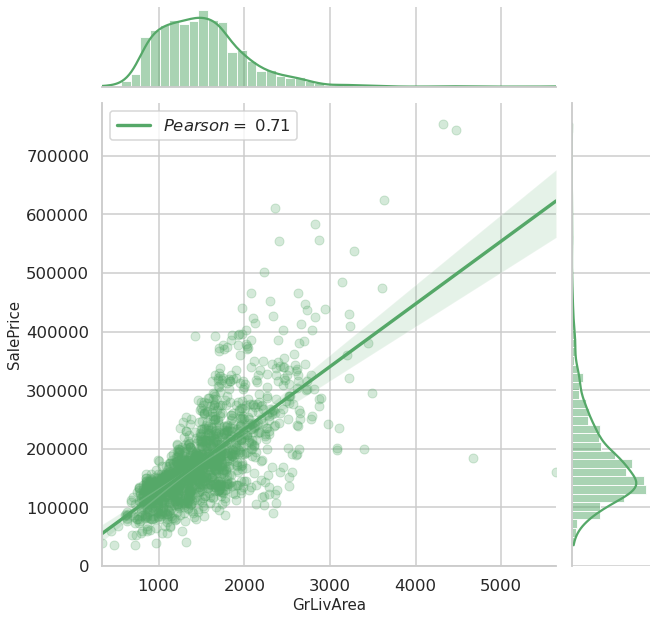

<Figure size 648x576 with 0 Axes>

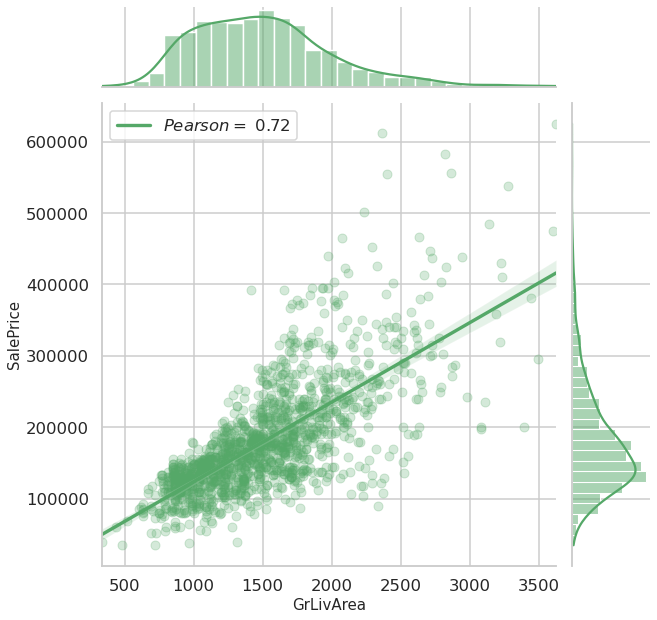

In [21]:
GrLivArea = data[[top[3], "SalePrice"]]
reg_plot(top[3], "SalePrice", GrLivArea)
#4500
data.drop(data[data.GrLivArea>4000].index, inplace = True)
GrLivArea = data[[top[3], "SalePrice"]]
reg_plot(top[3], "SalePrice", GrLivArea)

We pass to the year of construction of the house, described in ```YearBuilt```. I could identify that four records that were constructed before the 1900s were outliers by having a price greater than USD 250.000. I manage to remove them and increase the correlation.

<Figure size 648x576 with 0 Axes>

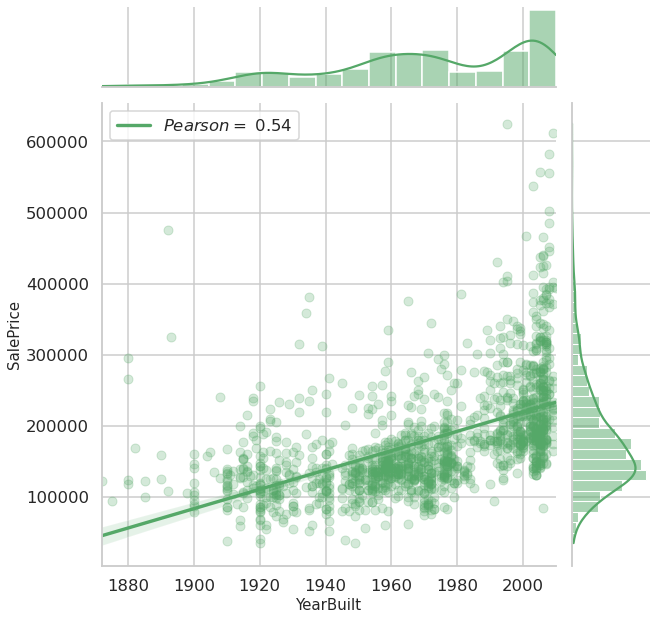

<Figure size 648x576 with 0 Axes>

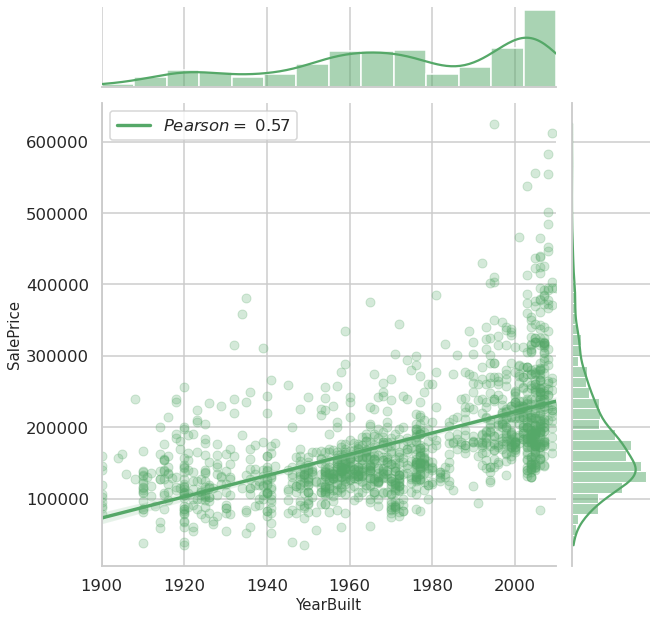

In [22]:
YearBuilt = data[[top[8], "SalePrice"]]
reg_plot(top[8], "SalePrice", YearBuilt)

# data.drop(data[(data.YearBuilt<1900) & (data.SalePrice > 250000)].index, inplace = True)
data.drop(data[(data.YearBuilt<1900)].index, inplace = True)

YearBuilt = data[[top[8], "SalePrice"]]  
reg_plot(top[8], "SalePrice", YearBuilt)
#0.52 -> 0.55

Continuing, the ```GarageArea``` showed me some outliers. The houses with garage areas with more than 1200 square feet were removed. We can see that it had a good effect in the correlation.

<Figure size 648x576 with 0 Axes>

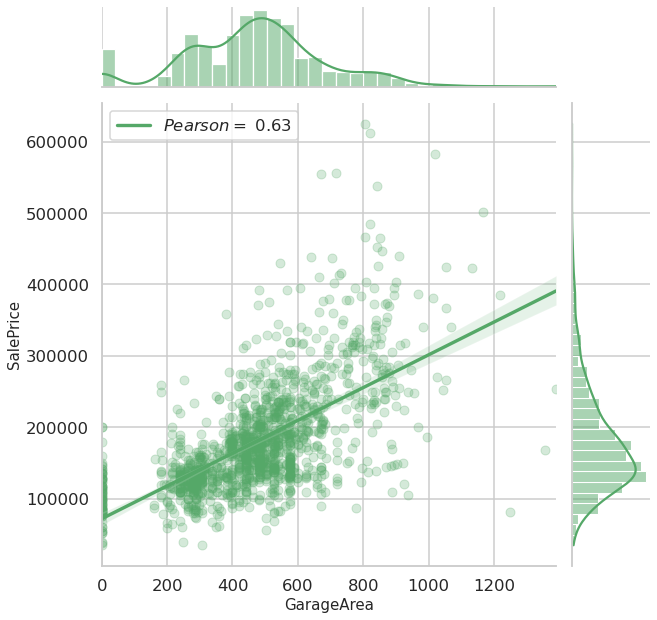

<Figure size 648x576 with 0 Axes>

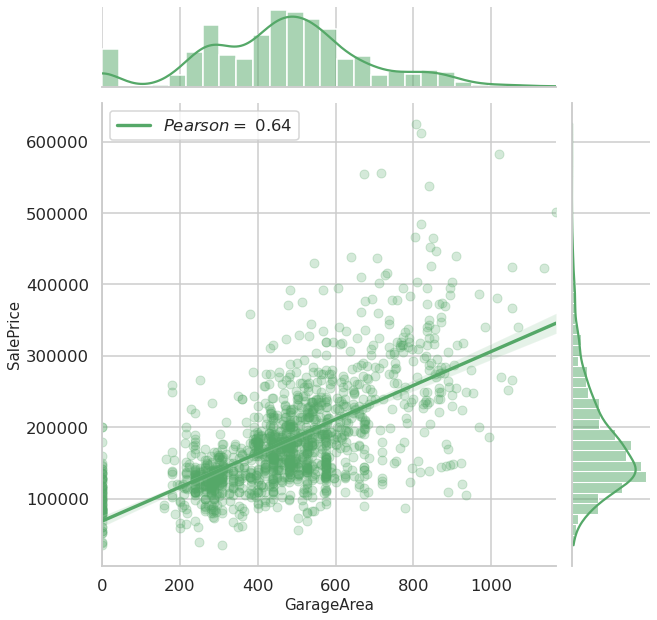

In [23]:
GarageArea = data[[top[9], "SalePrice"]]
reg_plot(top[9], "SalePrice", GarageArea)

data.drop(data[(data.GarageArea>1200)].index, inplace = True)

GarageArea = data[[top[9], "SalePrice"]]  
reg_plot(top[9], "SalePrice", GarageArea)

Lastly we have the trickiest atribute. Because as we saw early, the garage construction year (```GarageYrBlt```) can be descritive to the number of cars in the garage, as well as their area. With that in mind, I will try to remove the outliers.

However we can see that the obvious outliers are the houses without a garage, since the year is zero. If I remove they from the dataset, we will lost information about all the houses without a garage, not to mention that are 81 records, too many to simply drop. As a compromize, I chose to change the year of contruction of the houses without garage to the median year of construction. We don't need to worry about the information of having or not a garage, since this information is present in several other atributes describing the garage condition.

<Figure size 648x576 with 0 Axes>

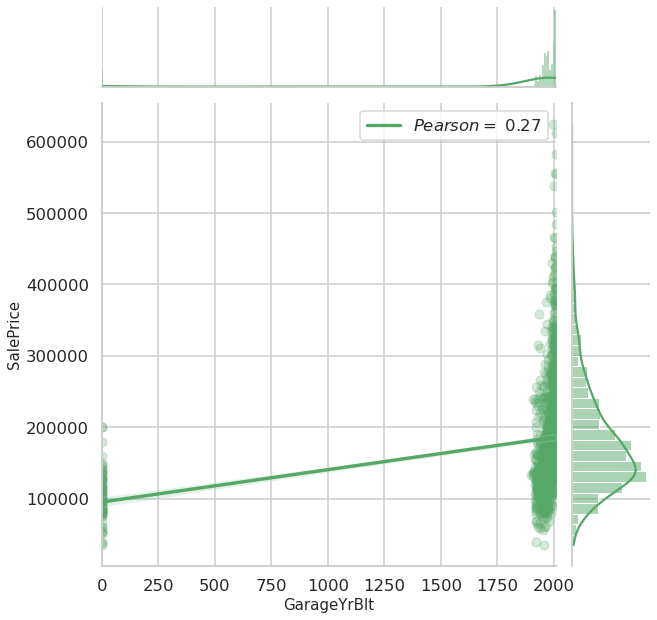

<Figure size 648x576 with 0 Axes>

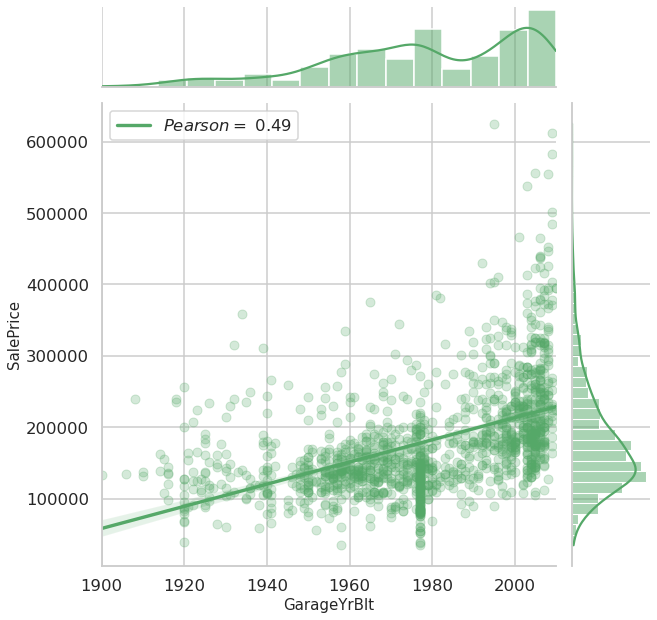

In [24]:
sns.set_theme(style="whitegrid", context="talk")
garageYrBlt = data[["GarageYrBlt", "SalePrice"]]
reg_plot("GarageYrBlt", "SalePrice", garageYrBlt)

for i in data[(data["GarageYrBlt"] == 0)].index:
    data.loc[i, "GarageYrBlt"] = data["GarageYrBlt"].median()

garageYrBlt = data[["GarageYrBlt", "SalePrice"]]    
reg_plot("GarageYrBlt", "SalePrice", garageYrBlt)

## Fixing skewness and enforcing normality 

Other important assumption of linear regression models is the normality of the variables. This means that the data should be close to a normal distribution, this is not a great issue, since our dataset has more than a thousand records, far more than necessary.

We can start by the dependent variable ```SalePrice```, and plot the distribution to see how the data is behaving.
There is a positive skewness, witch makes the atribute deviate from the normal distribution.

Kurtosis: 3.9626988199839617
Skewness: 1.5671940226687435


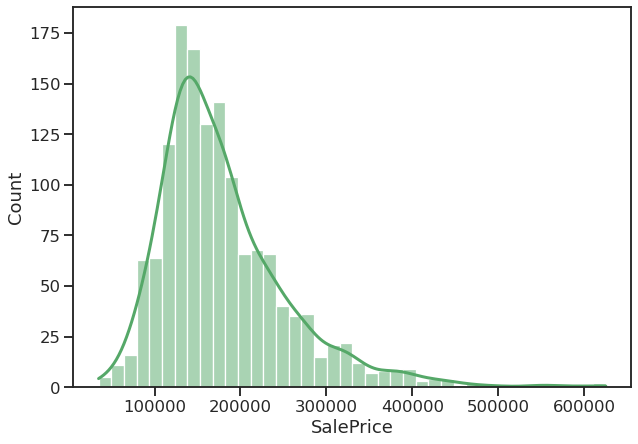

In [25]:
"""Ploting the distribution on SalePrice, as well as its Skewness and Kurtosis"""
plot_dist(data["SalePrice"])
print("Kurtosis:", data["SalePrice"].kurt())
print("Skewness:", data["SalePrice"].skew())

As we can see in the QQ-Plot, in the left, the data does not fit the red line that represent Gaussian-like data. To solve this problem, we can simply aply the $\log$ transformation, since the data is close to a $\log$-normal distribution. 

I chose to use the $\log$ instead of the Yeo-Johnson, because the $\log$ is simple to understand, simple to do an inverse, and get the job done. We need to be careful not to have a zero value in the array before apply the $\log$, since it is not defined. In this case it does not have, but otherwise we should use $\log{(1+x)}$ transformation. 

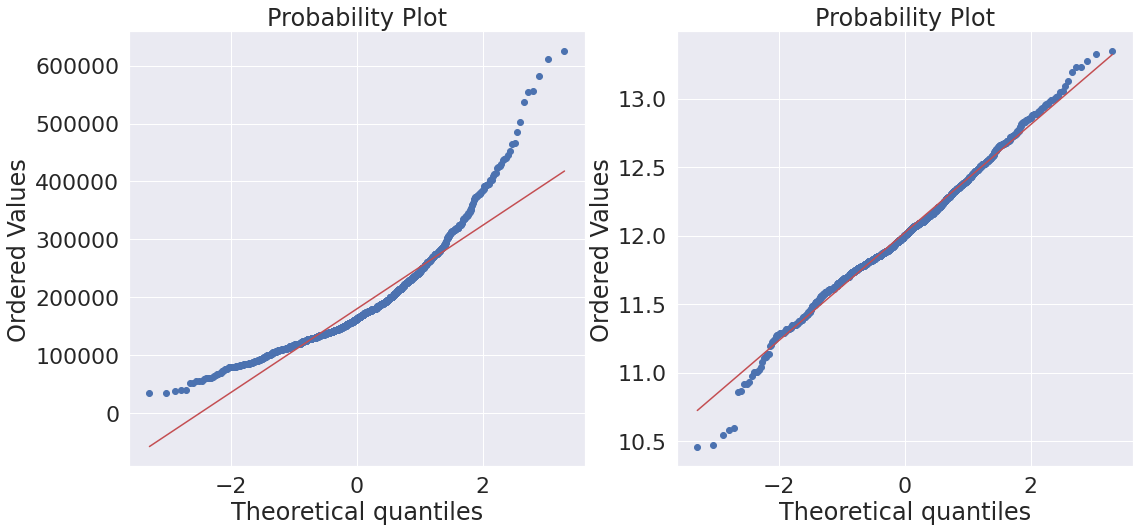

In [26]:
"""Checking the normality of the dependent variable. As we can see, the Log will work just fine"""
f,ax = plt.subplots(1,2,figsize=(18,8))
stats.probplot(np.log(data["SalePrice"]), plot=ax[1])
stats.probplot(data["SalePrice"],plot=ax[0])
plt.show()

data["SalePrice" + "_log"] = np.log(data["SalePrice"])

Here we are going to plot the distribution of the skewness across all the atributes, the farther from zero, the less simetric the distribution of data is, hence farther from Gaussian-like. We can see that most of the atributes has a skewness close to zero, and we need to deal with the columns that has high skewness.

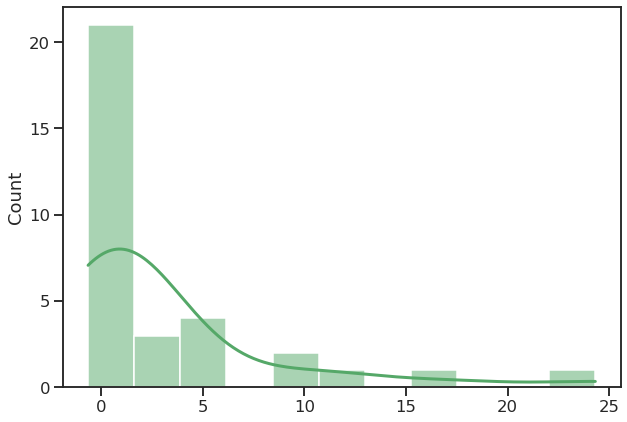

In [27]:
skewness = data[numerical].skew()
skewness.sort_values(inplace=True, ascending=False)
plot_dist(skewness)

To reduce skewness we are going to apply a Power Transformation featurewise. For this task I chose the Yeo-Johnson transformation, because during the tests it outperformed the Box-Cox transformation.

The Yeo-Johnson transformation can handle positive, zeros and negative numbers, so we don't need to worry about the intervals on witch the function is defined. The function is:


$y_i^{(\lambda)} = \begin{cases} ((y_i+1)^\lambda-1)/\lambda                      &  \text{if }\lambda \neq 0, y \geq 0 \\ 
                                \log(y_i + 1)                                    &  \text{if }\lambda =    0, y \geq 0 \\ 
                                -[(-y_i + 1)^{(2-\lambda)} - 1] / (2 - \lambda)  &  \text{if }\lambda \neq 2, y <    0 \\ 
                                -\log(-y_i + 1)                                  &  \text{if }\lambda =    2, y <    0 
                  \end{cases}
$


First we fit the scaler through the data to estimate the optimal parameter lambda for each atribute, then we can transform the data using these optimal lambdas. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood.

/opt/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


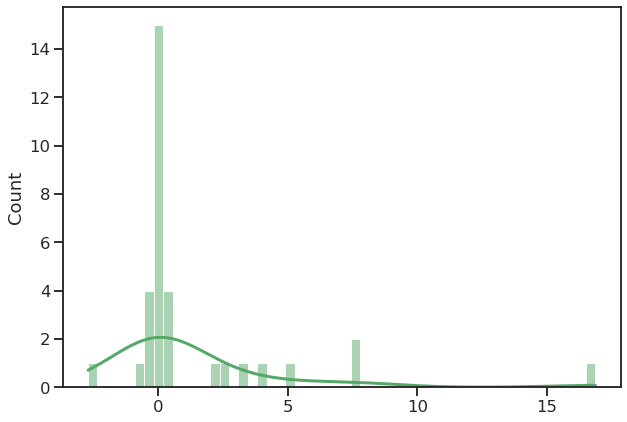

In [28]:
"""Performing data prossessing to mitigate the impacts of the lack of simetry on the distribution of values"""

scaler = PowerTransformer()
scaler.fit(data[numerical])
data_num_scaled = scaler.transform(data[numerical])
data_num_scaled = pd.DataFrame(data = data_num_scaled, columns = data[numerical].columns, index = data[numerical].index)
skewness_scaled = data_num_scaled.skew()
plot_dist(skewness_scaled)

As we can see, the ```PoolArea``` has a high skewness even after we made the transformation, we also know that it is the only one, so we can take a better look at this atribute.

In [29]:
"""The Series containing the skewness, we can see that PoolArea has the worst skewness"""
skewness_scaled.sort_values(ascending=False)

PoolArea         16.875969
LowQualFinSF      7.718516
3SsnPorch         7.547802
MiscVal           5.080353
BsmtHalfBath      3.849562
ScreenPorch       3.097426
BsmtFinSF2        2.396334
EnclosedPorch     2.077523
HalfBath          0.527580
MasVnrArea        0.416233
BsmtFullBath      0.346333
2ndFlrSF          0.304715
WoodDeckSF        0.133149
BedroomAbvGr      0.127645
YrSold            0.095100
Fireplaces        0.080506
LotArea           0.036113
TotRmsAbvGrd      0.002687
1stFlrSF         -0.000044
GrLivArea        -0.001041
OpenPorchSF      -0.014509
GarageCars       -0.032246
MoSold           -0.039063
TotalBsmtSF      -0.044176
FullBath         -0.056731
YearBuilt        -0.125828
GarageYrBlt      -0.129056
YearRemodAdd     -0.223249
BsmtUnfSF        -0.273318
GarageArea       -0.392586
BsmtFinSF1       -0.431074
LotFrontage      -0.609715
KitchenAbvGr     -2.712911
dtype: float64

As we see the ```PoolArea``` values, the area of the pools doesn't vary a lot, and it has only 7 records with values. Because of that, I'm going to drop that column. Keep in mind that we are not going to lose the information about the pool, since there is another pool atribute called ```PoolQC```.

[  0 512 648 576 519 738]


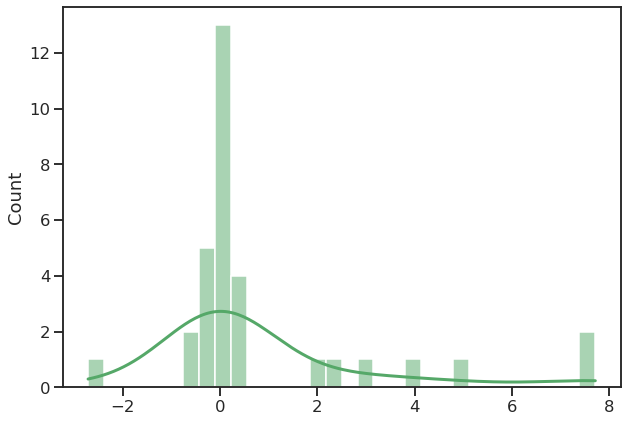

In [30]:
print(data["PoolArea"].unique())
numerical.remove("PoolArea")
plot_dist(data_num_scaled[numerical].skew())

## Evaluating the data changes
Once we finished the cleaning, encoding and transformation of the data we can compare the Pearson correlation after and before to see the impact of our interventions. I'm very pleased with the result.

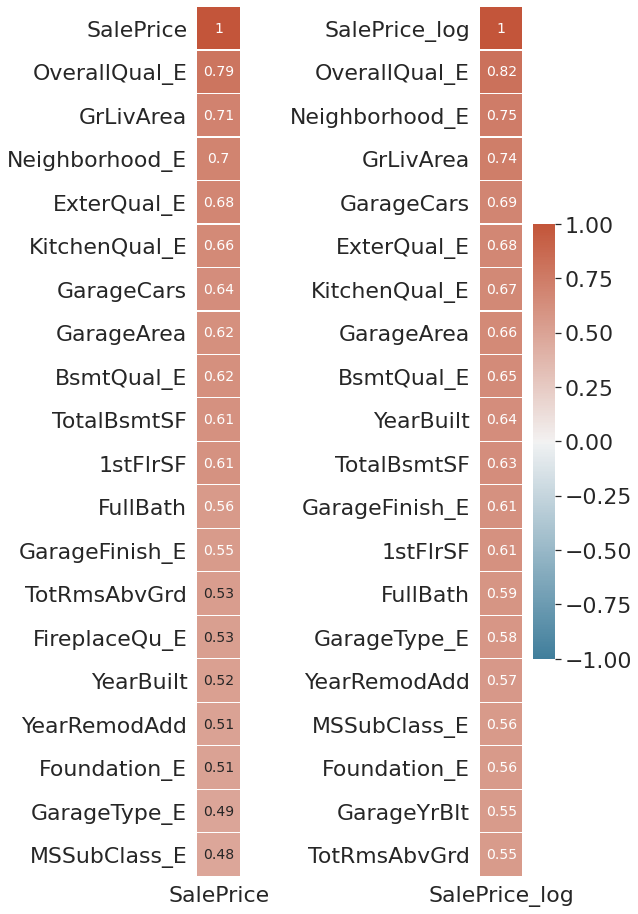

In [31]:
"""Comparing the correlation before and after the data transformations"""

frame = [data_num_scaled, data[cat_encoded + ["SalePrice", "SalePrice_log"]]]
data_concat = pd.concat(frame, axis=1)


corr_SalePrice_log = data_concat[numerical + cat_encoded + ["SalePrice_log"]].corr()

f, ax = plt.subplots(1, 2, figsize=(8, 16))
triang_corr_plot(corr_SalePrice[["SalePrice"]].sort_values(by=['SalePrice'],ascending=False).head(20), 
                 vmax=1, vmin=-1, mask=False, annot=True, annot_kws={"size": 14}, 
                 square=True, ax=ax[0], cbar=False, figsize=(0, 0))

triang_corr_plot(corr_SalePrice_log[["SalePrice_log"]].sort_values(by=['SalePrice_log'],ascending=False).head(20), 
                 vmax=1, vmin=-1, mask=False, annot=True, annot_kws={"size": 14}, 
                 square=True, ax=ax[1], figsize=(0, 0))

## Separating the independent and dependent variables 
Once we have all the NaN values dealt with, we can proceed to split the data in dependent variable and independent variables.
I'll use the conventional notation ```X``` for the independent variables and ```y``` to the dependent. I'm also transforming all the categorical data in dummy variables, that is, for each category of each column, I create a binary column to describe for witch records that category is true. 

As seen in this table:
    
|col1  | ->  |col1_cat1 |col1_cat2 |
   --- | --- | ---      | ---  
|cat1  | ->  |1         |0         |
|cat2  | ->  |0         |1         |

Just in case, we are also going to make another dataset of independent variable, but without the dummy variables, to compare how the models perform with each one of them. In the end I'll choose the best performing.


In [32]:
X = data_concat.copy()
X.drop(labels=["SalePrice", "SalePrice_log"], axis="columns", inplace=True)
X[cat_encoded] = X[cat_encoded].astype('int64')
X = pd.get_dummies(X, columns=cat_encoded)
X.head(10)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,OverallQual_E_10,OverallCond_E_1,OverallCond_E_2,OverallCond_E_3,OverallCond_E_4,OverallCond_E_5,OverallCond_E_6,OverallCond_E_7,OverallCond_E_8,OverallCond_E_9
0,0.307932,-0.131037,1.152204,0.909949,1.226017,0.797166,-0.362767,-0.877997,-0.427455,-0.800852,...,0,0,0,0,0,0,0,0,1,0
1,0.682264,0.117814,-0.001210,-0.615724,-0.822695,1.018448,-0.362767,-0.424407,0.534590,0.437987,...,0,0,0,0,0,0,1,0,0,0
2,0.384324,0.428932,1.055793,0.837904,1.188596,0.564049,-0.362767,-0.038231,-0.270847,-0.570915,...,0,0,0,0,0,0,0,0,1,0
3,0.178703,0.107605,-1.697602,-0.858019,-0.822695,0.124613,-0.362767,0.192941,-0.676732,-0.431834,...,0,0,0,0,0,0,0,0,1,0
4,0.779136,0.897733,1.008296,0.697962,1.330179,0.748661,-0.362767,0.087217,0.264373,0.127277,...,0,0,0,0,0,0,0,0,1,0
5,0.803179,0.877431,0.688640,0.371113,-0.822695,0.820877,-0.362767,-1.304802,-0.576311,-1.032518,...,0,0,0,0,0,0,0,0,1,0
6,0.559523,0.214086,1.201128,1.058322,1.215896,1.265713,-0.362767,-0.331577,1.477426,1.378975,...,0,0,0,0,0,0,0,0,1,0
7,-1.830068,0.271178,-0.111272,-0.740466,1.264018,0.928273,2.741324,-0.635695,0.175498,0.019524,...,0,0,0,0,0,1,0,0,0,0
8,-0.060657,-0.754523,-1.348873,-1.485606,-0.822695,-1.366044,-0.362767,0.916115,-0.193326,-0.235471,...,0,0,0,0,0,0,0,0,1,0
9,-0.087849,-0.383236,-1.151883,-1.485606,-0.822695,0.921878,-0.362767,-0.919332,-0.099514,-0.068178,...,0,0,0,0,0,1,0,0,0,0


In [33]:
X_linear = data_concat.copy()
X_linear.drop(labels=["SalePrice", "SalePrice_log"], axis="columns", inplace=True)
X_linear[cat_encoded] = X_linear[cat_encoded].astype('int64')
X_linear.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E,MSSubClass_E,OverallQual_E,OverallCond_E
0,0.307932,-0.131037,1.152204,0.909949,1.226017,0.797166,-0.362767,-0.877997,-0.427455,-0.800852,...,6,3,1,5,4,5,5,15,7,8
1,0.682264,0.117814,-0.001210,-0.615724,-0.822695,1.018448,-0.362767,-0.424407,0.534590,0.437987,...,6,3,1,5,4,5,5,12,6,6
2,0.384324,0.428932,1.055793,0.837904,1.188596,0.564049,-0.362767,-0.038231,-0.270847,-0.570915,...,6,3,1,5,4,5,5,15,7,8
3,0.178703,0.107605,-1.697602,-0.858019,-0.822695,0.124613,-0.362767,0.192941,-0.676732,-0.431834,...,6,3,1,5,4,5,2,10,7,8
4,0.779136,0.897733,1.008296,0.697962,1.330179,0.748661,-0.362767,0.087217,0.264373,0.127277,...,6,3,1,5,4,5,5,15,8,8


In [34]:
y = data_concat["SalePrice_log"].copy()
y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice_log, dtype: float64

## Setting the seed
This seed will be used in several functions, and I'll set to ```42```, because it is the answer to life, the universe and everything.

In [35]:
seed = 42 

## Split the data in train and test
Using the seed, I splited the data between train and test for both the ```X``` and ```y```. After that, I ploted the test and the train data to see if they look similar, and they do.

(1077,)
(359,)


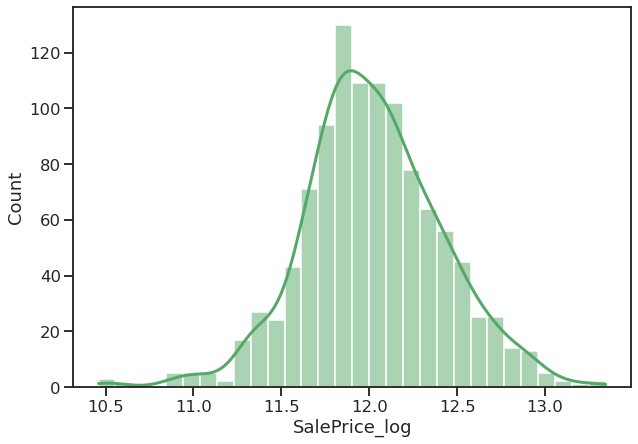

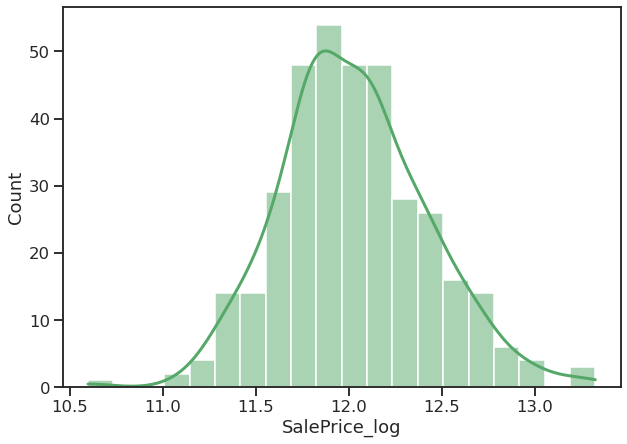

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

print(y_train.shape)
plot_dist(y_train)
print(y_test.shape)
plot_dist(y_test)

# Modeling Regressors
## Choosing the regressor models
Now we came to the main event. I wanted to build **several** models to learn how they work and witch one works best in this kind of data. So I made a huge list of models and studied witch of them I could use in regression.
After eliminating all the models used only in categorization, discarted also the plain Linear Regression and Decision Trees, because it do not fit the data and is prone to overfitting, respectively. 

I was left with the following list of models:

**Linear models:**
- Ridge Regression
- Lasso Regression
- ElasticNet
- Bayesian Ridge

**Ensemble Methods:**
- Random Forest
- Adaptive Boosting
- Gradient Tree Boosting

**Others:**
- Suport Vector Regression 
- K-Nearest Neighboors

Some of the models support the use of parallel computing, in this case whenever possible I used all the cores in the processor through the ```n_jobs = -1```.

In [95]:
randon_forest = RandomForestRegressor(n_estimators = 100, random_state = seed, n_jobs = -1)
adaboost = AdaBoostRegressor(random_state = seed)
gradient_boost = GradientBoostingRegressor(random_state = seed) 

ridge_regression = Ridge(random_state = seed) ##
lasso_regression = Lasso(random_state = seed) ##
elastic_net = ElasticNet(random_state = seed)
bayesian_ridge = BayesianRidge(n_iter = 500)

sv_regression = SVR()
knn = KNeighborsRegressor(n_jobs = -1)

tree_models_names = ["RandForest", "AdaBoost", "GradBoost"]
tree_models = [randon_forest, adaboost, gradient_boost]
 
linear_models_names = ["RidgeReg", "LassoReg", "ElasticNet", "BayesianRidge"]
linear_models = [ridge_regression, lasso_regression, elastic_net, bayesian_ridge]

other_models_names = ["SVReg", "KNN"]
other_models = [sv_regression, knn]

all_models_names = tree_models_names + linear_models_names + other_models_names
all_models = tree_models + linear_models + other_models

## Training and Evaluating Models
After selecting all the models that i was going to train, i then started to construct functions to train, evaluate, cross validate and plot the results. Finaly I combined all the elements in a function to return a DataFrame with all the information of root mean squared error, the cross validation score and the training score.

In [96]:
def train_model(model):
    model.fit(X_train, y_train)
    score = model.score(X_train, y_train)
    return score

def evaluate_rmse(model):
    prediction = model.predict(X_test)
    mse = mean_squared_error(prediction, y_test)
    rmse = np.sqrt(mse)
    return rmse

def cross_validation(model):
    cv_score = cross_val_score(model, X, y, cv = 10, n_jobs = -1, scoring = "neg_mean_squared_error")
    sq_cv_score = np.sqrt(-1*cv_score)
    return sq_cv_score.mean()

def train_and_evaluate(models):
    training_score = []
    evaluation_score = []
    cv_score = []
    for model in models:
        training_score.append(train_model(model))
        evaluation_score.append(evaluate_rmse(model))
        cv_score.append(cross_validation(model))

    train_score = pd.DataFrame()
    train_score["training_score"] = training_score
    train_score["rmse"] = evaluation_score
    train_score["cv_score"] = cv_score
    train_score.index = all_models_names
    return train_score

def plot_serie(data, x_label, **kwargs):
    sns.set_theme(style="whitegrid", context="talk")
    f, ax1 = plt.subplots(1, 1, figsize=(10, 7))
    sns.barplot(x=data.index, y=data.values, ax=ax1, orient="v", **kwargs)
    plt.xticks(ticks=range(0, len(data.index)), labels=data.index, rotation=90)
    sns.set(font_scale=2)
    ax1.set_xlabel(x_label)
    plt.plot()

In [97]:
train_score = train_and_evaluate(all_models)
train_score.sort_values(by="cv_score")

,training_score,rmse,cv_score
BayesianRidge,0.946554,0.107724,0.109614
RidgeReg,0.952796,0.111289,0.112321
GradBoost,0.961531,0.124758,0.122892
SVReg,0.960778,0.129123,0.131995
RandForest,0.980042,0.136674,0.139229
KNN,0.873299,0.163875,0.167442
AdaBoost,0.842313,0.180993,0.180508
LassoReg,0.000000,0.394334,0.393528
ElasticNet,0.000000,0.394334,0.393528


### R Squared
The training score is a function that computes te coefficient of determination, witch is defined as:

$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$, where $\hat{y}_i$ is the predicted value, and $y_i$  is the true value of the $i$-th record. The $n$ is the total number of records predicted.

The $R^2$, is the proportion of the variance in the dependent variable (```y```) that is predictable from the independent variables (```X```). Its best possible score is $1.0$ and it can be negative (because the model can be arbitrarily worse).

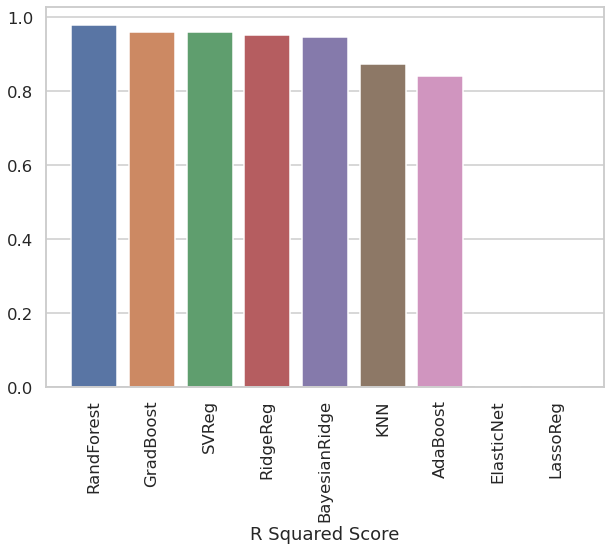

In [108]:
plot_serie(train_score["training_score"].sort_values(ascending=False), "R Squared Score")

### Root Mean Squared Error
First I created a train model function with the training score. Now I need a evaluation function, here I am using the Root Mean Squared Error, a risk function to calculate the expected value of the squared loss:

$\operatorname{rmse}=\sqrt{\frac{\sum_{i=1}^n (\hat y_i - y_i)^2}{n}}$, this function is used to calculate the distance between the predicted value $\hat y_i$ and de real $y_i$, over all the $n$ predictions.


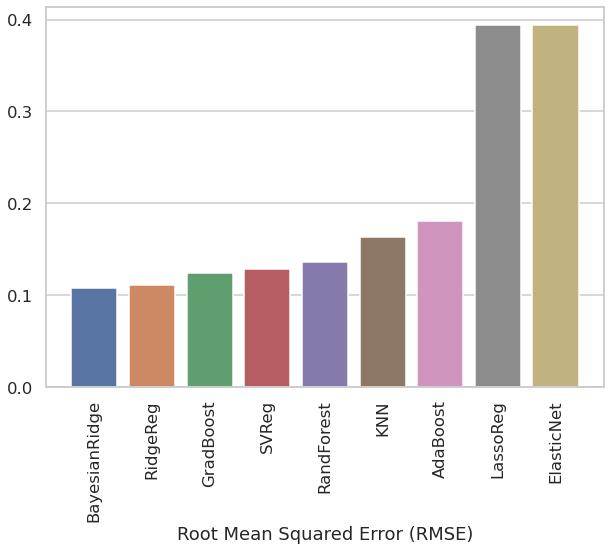

In [107]:
plot_serie(train_score["rmse"].sort_values(), "Root Mean Squared Error (RMSE)")

### K-Fold Cross Validation
Another function that I made was the aplication of a K-Fold cross-validation. It is important because it is a simple and effective way of training and evaluating the model. The  K-Fold cross-validation split dataset into $k$ consecutive folds, each fold is then used once as a validation while the $k-1$ remaining folds form the training set, as we can see in this 5-fold cross validation example:

<img src="https://i.stack.imgur.com/1fXzJ.png" alt="winter" style="width:720px;"/>

Then this cross-validation experiment averages all the $\operatorname{rmse}$ values and gives us a $\operatorname{rmse}$ that we can have a better confidence on how the model is going to perform.

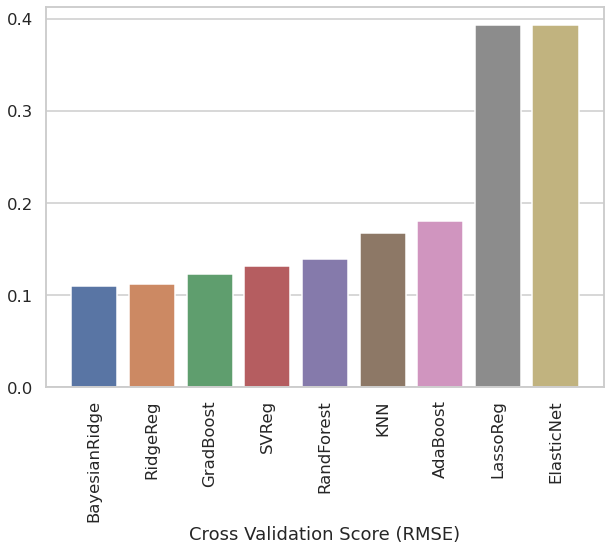

In [106]:
plot_serie(train_score["cv_score"].sort_values(), "Cross Validation Score (RMSE)")

## Hyperparameters Optimization
Once we trained our models, we need to optimize each one of them. For that, we need to make experiments.

One important aspect of experimentation is the hability to save all the result

In [43]:
def hyperparameters_optimization(model, param_distributions, X, y):
    dist = RandomizedSearchCV(model, param_distributions, n_iter = 100, cv = 10, verbose = 1, 
                              scoring = 'neg_root_mean_squared_error', n_jobs = -1)
    dist.fit(X, y)
    cv_results = dist.cv_results_
    best_estimator = dist.best_estimator_
    best_params = dist.best_params_ 
    best_score = -1 * dist.best_score_
    return cv_results, best_estimator, best_params, best_score

def save_experiment(model_name, data_X, y, cv_results):
    if not os.path.isdir('../experiments/' + model_name):
        os.mkdir('../experiments/' + model_name, mode=0o777, dir_fd=None)
        
    directory = '../experiments/' + model_name + "/" + datetime.datetime.now().isoformat()
    os.mkdir(directory, mode=0o777, dir_fd=None)
    os.mkdir(directory + "/data", mode=0o777, dir_fd=None)
    
    df_cv_results = pd.DataFrame(cv_results).sort_values(by="rank_test_score")
    df_cv_results.to_csv(directory + "/cv_results.csv")
    data_X.to_csv(directory + "/data/X.csv")
    y.to_csv(directory + "/data/y.csv")


### Ridge Regression
The ridge regression is a linear model with coefficients $w = (w_1, ..., w_p)$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Additionaly, this model has a $\alpha ||w||_2^2$ where $\alpha$ is a constant ($\alpha \ge 0$) and $||w||_2^2$ is the Euclidian norm of the $w$ coefficients vector.

<center>
$\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2$
</center>

In [54]:
model_name = "RidgeReg"
data_X = X
ridge_param_dist = {"alpha": np.linspace(1, 11, num=2000),
                    "solver": ["svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
                    'random_state': [seed]}

cv_results, ridge_best_estimator, ridge_best_params, ridge_best_score = hyperparameters_optimization(ridge_regression, ridge_param_dist, data_X, y)
save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished


In [55]:
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(ridge_best_params, ridge_best_score))

RidgeReg best params:{'solver': 'cholesky', 'random_state': 42, 'alpha': 6.117558779389695} 
Best_score:0.10951911


### Lasso Regression
The lasso regression is a linear model that estimates sparse coefficients, that is, the number of non-zero coeficients is low, and the zero coefficients is used as a blade to cut down the unimportant atributes, reducing the number of atributes that the target depends on.


Its a linear model with coefficients $w = (w_1, ..., w_p)$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Additionaly, this model has a $\alpha ||w||_1$ where $\alpha$ is a constant and $||w||_1$ is the norm of the $w$ coefficients vector.

This model tries to minimize the lest-squared funcion with an regularization term:

<center>
$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$
</center>

In [56]:
model_name = "LassoReg"
data_X = X

lasso_param_dist = {"alpha": np.linspace(0.00001, 0.001, num=2000),
                    'random_state': [seed]}

cv_results, lasso_best_estimator, lasso_best_params, lasso_best_score = hyperparameters_optimization(lasso_regression, lasso_param_dist, data_X, y)
save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   45.8s finished


In [57]:
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(lasso_best_params, lasso_best_score))

LassoReg best params:{'random_state': 42, 'alpha': 0.0003061580790395198} 
Best_score:0.10758331


### ElasticNet Regression
The elasticnet regression is a linear model that combines the lasso regression and the ridge regression. It has the euclidian norm $||w||_2 ^ 2$ as well as the norm $||w||_1$ of the coefficients vector $w = (w_1, ..., w_p)$.

There is a $\alpha$ value for both of these regularization terms, and additionaly we have a $\rho$ value (```l1_ratio```) to determine the impact of each the regularization term.

This model tries to minimize the lest-squared funcion with two regularization terms:
<center>
$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha \rho ||w||_1 +
\frac{\alpha(1-\rho)}{2} ||w||_2 ^ 2}$
</center>

In [58]:
model_name = "ElasticNet"
data_X = X

elastic_net_param_dist = {"alpha": np.linspace(0.00001, 0.001, num=2000),
                          'l1_ratio': np.linspace(0.001, 1, num=2000),
                          'random_state': [seed]}

cv_results, elastic_net_best_estimator, elastic_net_best_params, elastic_net_best_score = hyperparameters_optimization(elastic_net, elastic_net_param_dist, data_X, y)
save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished


In [59]:
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(elastic_net_best_params, elastic_net_best_score))

ElasticNet best params:{'random_state': 42, 'l1_ratio': 0.9685157578789394, 'alpha': 0.0003289394697348675} 
Best_score:0.10759093


### Bayesian Ridge Regression
Bayesian regression techniques can be used to include regularization parameters in the estimation procedure: the regularization parameter is not hardcoded, insted the model uses inference on the data to find the best parameters.

The prior used for the coefficient $w$ is given by a spherical Gaussian:

<center>
$p(w|\lambda) = \mathcal{N}(w|0,\lambda^{-1}\mathbf{I}_{p})$
</center>

The output $y$ is assumed to be Gaussian distributed around $Xw$:

<center>
$p(y|X,w,\alpha) = \mathcal{N}(y|X w,\alpha)$
</center>

The parameters $w$,$\alpha$ and $\lambda$ are estimated jointly during the fit of the model, the regularization parameters $\alpha$ and $\lambda$ being estimated by maximizing the *log marginal likelihood*.

The $\alpha$ and $\lambda$ are chosen to be gamma distributions, and the ```alpha_1```, ```alpha_2```, ```lambda_1```, ```lambda_2``` are the hyper parameters of the gamma prior.

I really like this model, not just because the update of the hyperparameters are done as suggested by one of my favorites information theorist David McKay, but also because the way it uses the data to infer the hyperparameters it's a very smart way to recognize the evidence of the data instead of guessing the hyperparameters to be used.

This approach is demonstrably good, by seeing the results of the Bayesian regression in comparisson with the others, and it does that with none hyperperparameter optimization. It is information theory at its finest.

In [86]:
model_name = "BayesianRidge"
data_X = X

bayesian_ridge_param_dist = {"alpha_1": np.linspace(1e-05, 1e-07, num=2000),
                             "alpha_2": np.linspace(1e-05, 1e-07, num=2000),
                             "lambda_1": np.linspace(1e-05, 1e-07, num=2000),
                             "lambda_2": np.linspace(1e-05, 1e-07, num=2000)}

cv_results, bayesian_ridge_best_estimator, bayesian_ridge_best_params, bayesian_ridge_best_score = hyperparameters_optimization(bayesian_ridge, bayesian_ridge_param_dist, data_X, y)
save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished


In [88]:
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(bayesian_ridge_best_params, bayesian_ridge_best_score))

BayesianRidge best params:{'lambda_2': 1e-05, 'lambda_1': 1.0990495247623979e-07, 'alpha_2': 6.939369684842422e-06, 'alpha_1': 6.439169584792397e-06} 
Best_score:0.10961360


### Random Forest Regression
A random forest is a meta estimator that fits a number of classifying decision trees (controled by ```n_estimators```) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

Others parameters are important to control the trees created, like the ```max_depth``` witch controls the maximum depth of the trees created by the model. The  ```min_samples_split``` represents the minumum number of samples with diferent values in a node to split it. While the ```min_samples_leaf``` is used to represent the minumum number of samples needed to construct the leaf nodes. A split point at any depth will only be considered if it leaves at least ```min_samples_leaf``` training samples in each of the left and right branches.

In [62]:
model_name = "RandForest"
data_X = X

randon_forest_param_dist = {'n_estimators': np.linspace(100, 250, num=10, dtype=int), 
                            'max_depth': np.linspace(40, 200, num=60, dtype=int),
                            'min_samples_split': np.linspace(2, 7, num=5, dtype=int),
                            'min_samples_leaf': np.linspace(1, 3, num=3, dtype=int),
                            'random_state':[seed]}

cv_results, randon_forest_best_estimator, randon_forest_best_params, randon_forest_best_score = hyperparameters_optimization(randon_forest, randon_forest_param_dist, data_X, y)
save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.1min finished


In [63]:
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(randon_forest_best_params, randon_forest_best_score))

RandForest best params:{'random_state': 42, 'n_estimators': 166, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 115} 
Best_score:0.13839915


### Adaptive Boost
The adaptive boost works by combining a sequence of weak learners, in our case a sequence of stumps (decision trees with only 3 node, 2 beeing leafs), into a weighted sum that represents the final output of the boosted classifier.

Each weak learner produces an output, $h(x_i)$, for each sample in the training set. At each iteration $t$, a weak learner is selected and assigned a coefficient $\alpha_t$ such that the sum training error $E_t$ of the resulting $t$-stage boost classifier is minimized.
<center>
$E_t = \sum_i E[F_{t-1}(x_i) + \alpha_t h(x_i)]$
</center>

Here $F_{t-1}(x)$ is the boosted classifier that has been built up to the previous iteration of training, $E(F)$ is some error function and $f_t(x) = \alpha_t h(x)$ is the weak learner that is being considered for addition to the final classifier.

The data modifications at each so-called boosting iteration consist of applying weights
$w_{i,t}$ is assigned to each sample in the training set equal to the current error $E(F_{t-1}(x_i))$ on that sample. Initially, those weights are all set to $w_i = 1/N$, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data.
As the algorith proceeds, each weak learner has to concentrate on the examples that are missed by the previous ones in the sequence.

In [64]:
model_name = "AdaBoost"
data_X = X

adaboost_param_dist = {"n_estimators": np.linspace(200, 1500, num=100, dtype=int), 
                       "learning_rate": np.linspace(3, 8, num=2000),
                       "loss": ["linear", "square", "exponential"],
                       'random_state':[seed]}

cv_results, adaboost_best_estimator, adaboost_best_params, adaboost_best_score = hyperparameters_optimization(adaboost, adaboost_param_dist, data_X, y)
save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 39.8min finished


In [65]:
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(adaboost_best_params, adaboost_best_score))

AdaBoost best params:{'random_state': 42, 'n_estimators': 1184, 'loss': 'exponential', 'learning_rate': 4.863431715857929} 
Best_score:0.16758007


### Gradient Tree Boosting
Gradient Tree Boosting is a generalization of boosting to arbitrary differentiable loss functions.

Similar to the AdaBoost, it is constructed in a greedy fashion, and each prediction $\hat{y_i} = F_M(x_i)$ is constructed as a weighted sum of all the estimators.

It all begins with a leaf node with the average of the target values:
<center>
$F_0(x) = \underset{\gamma}{\arg\min} \sum_{i=1}^n L(y_i, \gamma)$.
</center>

After that, the algorith will create trees, and for each tree (until it reaches the maximum $M$, that is, ```n_estimators```) it will calculate the pseudoresiduals (the error between the prediction by the last iteration and the target value):
<center>
$r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial 
F(x_i)}\right]_{F(x)=F_{m-1}(x)} \quad \mbox{for } i=1,\ldots,n$
</center>

Then it computes the $\gamma$ multiplier of the tree: 
<center>
$\gamma_m = \underset{\gamma}{\operatorname{arg\,min}} \sum_{i=1}^n L\left(y_i, F_{m-1}(x_i) + \gamma h_m(x_i)\right)$
</center>

Lastly, it computes the updated model with the learning rate $\nu$ (```learning_rate```)  :
<center>
$F_m(x) = F_{m-1}(x) + \nu  \gamma_m h_m(x)$
</center>

After all that, we are going to have our model and its predictions.
The last parameters that are being optimized are ```max_depth``` and ```subsample``` that are used to control the maximum depth of the trees and the fraction of samples to be used for fitting the individual base learners as a control of bias and variance.

In [66]:
model_name = "GradBoost"
data_X = X

gradient_boost_param_dist = {"n_estimators": np.linspace(500, 1000, num=5, dtype=int), 
                             "learning_rate": np.linspace(0.0001, 1, num=2000),
                             "subsample": np.linspace(0.0001, 1, num=2000),
                             "min_samples_split": np.linspace(2, 7, num=5, dtype=int),
                             "min_samples_leaf": np.linspace(1, 3, num=3, dtype=int),
                             "max_depth": np.linspace(45, 65, num=20, dtype=int),
                             "random_state":[seed]}

cv_results, gradient_boost_best_estimator, gradient_boost_best_params, gradient_boost_best_score = hyperparameters_optimization(gradient_boost, gradient_boost_param_dist, data_X, y)
save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 83.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 102.7min finished


In [67]:
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(gradient_boost_best_params, gradient_boost_best_score))

GradBoost best params:{'subsample': 0.37725087543771885, 'random_state': 42, 'n_estimators': 1000, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 63, 'learning_rate': 0.016606603301650827} 
Best_score:0.11995281


### Support Vector Machine for Regression
In this one I'll not enter in the math so much, because it can deviate us from our course.
Mainly, the support vector machine creates a hyperplane in space of the data to act as a regression function for the data.

The main objective is to find a $w \in \mathbb{R}^p$, such that the prediction provided by $w^T\phi(x) + b$ is the closest to the actual value in most samples. The ```kernel``` trick uses a function to map the input values to a higher dimention, where is easier to fit the hyperplane. Here I use the Radial Basis Function: 
<center>
$\exp(-\gamma \|x-x'\|^2)$
</center>

The parameter ```C```, trades off misclassification of training examples against simplicity of the decision surface, that is, low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. While  $\gamma$ (```gamma```) defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected. The $\varepsilon$ (```epsilon```) parameter is a error threshold.

After that we are ready to to arrive at the soluction by minimizing the following function:
<center>
$\min_ {w, b} \frac{1}{2} w^T w + C \sum_{i=1}\max(0, |y_i - (w^T \phi(x_i) + b)| - \varepsilon)$,
</center>

In [70]:
model_name = "SVReg"
data_X = X

sv_regression_param_dist = {"kernel": ["rbf"],
                            "C": np.linspace(5, 10, num=5, dtype=int),
                            "gamma": np.linspace(0.0001, 0.01, num=2000),
                            "epsilon": np.linspace(0.001, 0.04, num=2000)}

cv_results, sv_regression_best_estimator, sv_regression_best_params, sv_regression_best_score = hyperparameters_optimization(sv_regression, sv_regression_param_dist, data_X, y)
save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.0min finished


In [71]:
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(sv_regression_best_params, sv_regression_best_score))

SVReg best params:{'kernel': 'rbf', 'gamma': 0.0013084042021010507, 'epsilon': 0.019339169584792395, 'C': 8} 
Best_score:0.10798708


### K-Nearest Neighboors
The target variable is predicted by local interpolation of the targets associated of the $k$ nearest neighbors in the training set, in the algorithm it is controled by ```n_neighbors```. 

The KD tree is a binary tree structure which recursively partitions the parameter space along the data axes, dividing it into nested orthotropic regions into which data points are filed. The basic nearest neighbors regression uses uniform weights (```weights```), that is, each point in the local neighborhood contributes uniformly to the classification of a query point.

The default value, is uniform, assigns equal weights to all points. the distance assigns weights proportional to the inverse of the distance from the query point.

In [102]:
model_name = "KNN"
data_X = X

knn_param_dist = {"n_neighbors": np.linspace(5, 35, num=30, dtype=int),
                  "algorithm": ["kd_tree"],
                  "leaf_size": np.linspace(15, 45, num=30, dtype=int),
                  "weights": ["uniform", "distance"]}

cv_results, knn_best_estimator, knn_best_params, knn_best_score = hyperparameters_optimization(knn, knn_param_dist, data_X, y)
save_experiment(model_name, data_X, y, cv_results)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.3min finished


In [103]:
print(model_name + ' best params:{} \nBest_score:{:0.8f}' .format(knn_best_params, knn_best_score))

KNN best params:{'weights': 'distance', 'n_neighbors': 6, 'leaf_size': 38, 'algorithm': 'kd_tree'} 
Best_score:0.16599917


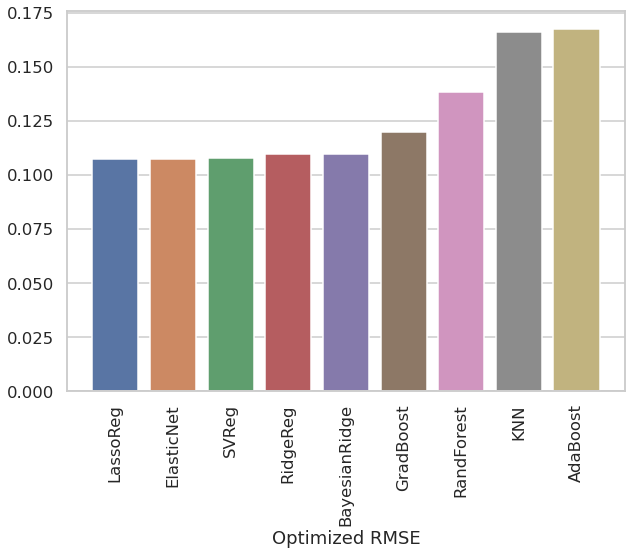

In [105]:
best_scores = [randon_forest_best_score, adaboost_best_score, gradient_boost_best_score, 
               ridge_best_score, lasso_best_score, elastic_net_best_score, bayesian_ridge_best_score,
               sv_regression_best_score, knn_best_score]

df_best_scores = pd.DataFrame()
df_best_scores["rmse_op"] = best_scores
df_best_scores.index = all_models_names

plot_serie(df_best_scores["rmse_op"].sort_values(), "Optimized RMSE")